# 3D U-Net Brain Tumor Segmentation Notebook (Multi-Class)

This notebook demonstrates a complete pipeline for **true multi-class** brain tumor segmentation using a 3D U-Net on BRATS data:
- Loading NIfTI volumes with SimpleITK
- Creating a PyTorch Dataset and DataLoader
- Remapping BRATS labels to contiguous class indices
- Defining a 3D U-Net model for multi-class output using MONAI
- Training with early stopping (patience pattern)
- Plotting training and validation loss curves
- Performing inference and visualizing multi-class results

## 1. Install Dependencies

Ensure MONAI, SimpleITK, and other necessary libraries are installed.

In [1]:
# 1) Restart your runtime (Runtime → Restart runtime).

# 2) In a single cell, uninstall the mismatched bits and reinstall only what you really need:
!pip install --upgrade pip
!pip uninstall -y numpy scikit-learn monai diffusers
!pip install numpy==2.3.0 scikit-learn==1.7.0 monai[nibabel]==1.3.0 diffusers SimpleITK matplotlib tqdm

# (Do NOT pip-install torch/torchvision here — we'll use Colab’s pre-installed build.)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: diffusers 0.33.1
Uninstalling diffusers-0.33.1:
  Successfully uninstalled diffusers-0.33.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 142.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 149.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 141.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy, sklearn, monai
print(numpy.__version__, sklearn.__version__, monai.__version__)
# Should be: 1.26.8 1.7.0 1.2.0

2.3.0 1.7.0 1.3.0


## 2. Imports

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [6]:
# 🖥️ Check environment
print("✅ GPU available:", torch.cuda.is_available())
print("🧠 Torch version:", torch.__version__)
print("📦 NumPy version:", np.__version__)
print("🩻 SimpleITK version:", sitk.Version_VersionString())
print("🧠 MONAI version:", UNet.__module__.split('.')[0])

✅ GPU available: True
🧠 Torch version: 2.6.0+cu124
📦 NumPy version: 2.3.0
🩻 SimpleITK version: 2.5.0
🧠 MONAI version: monai


## 3. Dataset Definition (with Label Remapping)

We define a custom Dataset that reads raw and label NIfTI files, remaps label values to `[0..C-1]`, and returns tensors.

In [5]:
#Prepare Colab data for work

from google.colab import drive
drive.mount('/content/drive')

#copy dataset to /content for faster access  on colab!
!mkdir /content/data
#!cp -r "/content/drive/MyDrive/00-DataScience_BIU/Final Project/data/IXI-T1_resampled" /content/data/IXI-T1_resampled/
!cp -r "/content/drive/MyDrive/00-DataScience_BIU/Final Project/data/T1_tumor_resampled"          /content/data/T1_tumor_resampled/
!cp -r "/content/drive/MyDrive/00-DataScience_BIU/Final Project/data/Tumor_labels_resampled"      /content/data/Tumor_labels_resampled/

!cp -r "/content/drive/MyDrive/00-DataScience_BIU/Final Project/data/T1_tumor_test_resampled"     /content/data/T1_tumor_test_resampled/

!cp -r "/content/drive/MyDrive/00-DataScience_BIU/Final Project/data/T1_tumor_test_group_resampled"     /content/data/T1_tumor_test_group_resampled/
!cp -r "/content/drive/MyDrive/00-DataScience_BIU/Final Project/data/Tumor_labels_test_group_resampled" /content/data/Tumor_labels_test_group_resampled/


Mounted at /content/drive


In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, label_paths, label_mapping=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.mapping = label_mapping or {}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load raw image
        img = sitk.ReadImage(self.image_paths[idx])
        img_arr = sitk.GetArrayFromImage(img).astype(np.float32)
        img_arr = (img_arr - img_arr.mean()) / img_arr.std()
        img_tensor = torch.from_numpy(img_arr).unsqueeze(0)  # [1, D, H, W]

        # Load and remap label using SimpleITK
        lbl = sitk.ReadImage(self.label_paths[idx])
        lbl_arr = sitk.GetArrayFromImage(lbl).astype(np.int64)
        # Remap original BRATS labels (e.g., {0,1,2,4}) -> {0,1,2,3}
        for orig, new in self.mapping.items():
            lbl_arr[lbl_arr == orig] = new
        lbl_tensor = torch.from_numpy(lbl_arr)  # [D, H, W]

        return img_tensor, lbl_tensor

## 4. Prepare DataLoaders with Train/Val Split

Directories for input and label volumes. Automatically detect classes to build mapping.

In [8]:
import os

image_dir = '/content/data/T1_tumor_resampled/'
label_dir = '/content/data/Tumor_labels_resampled/'

images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii.gz')])
labels = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii.gz')])

first_lbl = nib.load(labels[0]).get_fdata().astype(int)
classes = sorted(np.unique(first_lbl))
print(f"Original classes in labels: {classes}")

mapping = {orig: idx for idx, orig in enumerate(classes)}
num_classes = len(classes)
print(f"Mapping {mapping}, num_classes={num_classes}")

train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True
)

train_ds = BrainTumorDataset(train_imgs, train_lbls, label_mapping=mapping)
val_ds   = BrainTumorDataset(val_imgs,   val_lbls,   label_mapping=mapping)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=1)

Original classes in labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Mapping {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3}, num_classes=4


## 5. Model, Loss, Optimizer for Multi-Class

Define a MONAI 3D U-Net with `out_channels=num_classes`, plus DiceLoss and CrossEntropy.

In [9]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

dice_loss = DiceLoss(to_onehot_y=True, softmax=True)
ce_loss   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 6. Training with Early Stopping

Monitor combined Dice + CE loss.

In [ ]:
num_epochs = 100
patience = 10
best_val_loss = float('inf')
counter = 0
train_losses, val_losses = [], []
checkpoint_path = 'best_multiclass_model.pth'

for epoch in range(1, num_epochs+1):
    model.train()
    epoch_train_loss = 0.0
    for imgs, lbls in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        imgs = imgs.to(device)
        lbls = lbls.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        lbls_chan = lbls.unsqueeze(1)
        d_loss    = dice_loss(outputs, lbls_chan)
        ce        = ce_loss(outputs, lbls)
        loss      = d_loss + ce

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            outputs = model(imgs)
            lbls_chan = lbls.unsqueeze(1)
            d_loss    = dice_loss(outputs, lbls_chan)
            ce        = ce_loss(outputs, lbls)
            epoch_val_loss += (d_loss + ce).item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch} -> Train: {epoch_train_loss:.4f} | Val: {epoch_val_loss:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint_path = f"/content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/3D_UNET_loss-{epoch_val_loss:.4f}_ep-{epoch}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

NameError: name 'model' is not defined

## 7. Plot Loss Curves

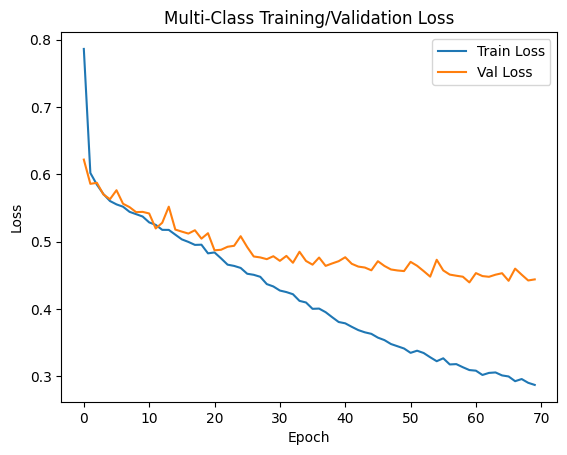

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-Class Training/Validation Loss')
plt.legend()
plt.show()

## 8. Inference and Multi-Class Visualization

Load best model, infer on a sample, and overlay each class with distinct colors.

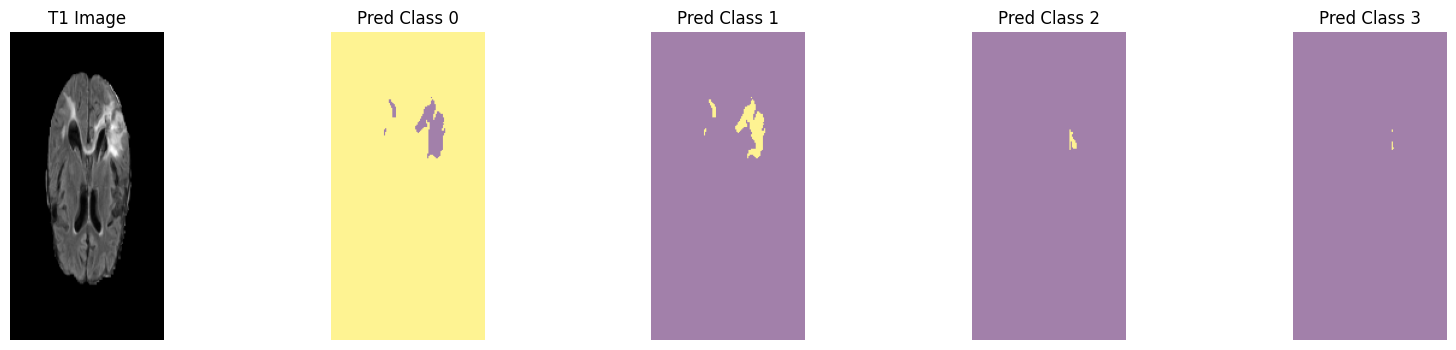

In [10]:
#middle
#checkpoint_path = r'/content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/3D_UNet_Brain_Tumor_Segmentation_multiclass_complete/3D_UNET_loss-0.4639_ep-38.pth'
#overfit
checkpoint_path = r'/content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/3D_UNet_Brain_Tumor_Segmentation_multiclass_complete/3D_UNET_loss-0.4394_ep-60.pth'
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

img, lbl = val_ds[0]
with torch.no_grad():
    inp = img.unsqueeze(0).to(device)
    pred = model(inp)
    pred_soft = torch.softmax(pred, dim=1)
    pred_label = torch.argmax(pred_soft, dim=1).cpu().numpy()[0]

img_np = img.numpy()[0]
lbl_np = lbl.numpy()

slice_idx = img_np.shape[0] // 2

fig, axes = plt.subplots(1, num_classes+1, figsize=(4*(num_classes+1),4))
axes[0].imshow(img_np[slice_idx], cmap='gray')
axes[0].set_title('T1 Image')
axes[0].axis('off')

for c in range(num_classes):
    axes[c+1].imshow(pred_label[slice_idx] == c, alpha=0.5)
    axes[c+1].set_title(f'Pred Class {c}')
    axes[c+1].axis('off')

plt.show()


## 9. Inference on a Test NIfTI

In [ ]:
#Add a new code cell below to run inference on a raw NIfTI and save the segmentation result:

# Paths to the input test image and desired output segmentation
test_image_path = r'/content/data/T1_tumor_eval_resampled/BRATS_470_T1.nii.gz'
output_seg_path = r'/content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/BRATS_470_predict_seg.nii.gz'

# Load and preprocess the test image
img = sitk.ReadImage(test_image_path)
img_arr = sitk.GetArrayFromImage(img).astype(np.float32)
img_arr = (img_arr - img_arr.mean()) / img_arr.std()
# Create tensor of shape [B, C, D, H, W]
img_tensor = torch.from_numpy(img_arr).unsqueeze(0).unsqueeze(0).to(device)

# Load best model weights and run inference
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
with torch.no_grad():
    pred = model(img_tensor)  # output shape [1, num_classes, D, H, W]
    pred_soft = torch.softmax(pred, dim=1)
    pred_label = torch.argmax(pred_soft, dim=1).cpu().numpy()[0]  # shape [D, H, W]

# Convert to SimpleITK image and save
seg = sitk.GetImageFromArray(pred_label.astype(np.uint8))
seg.CopyInformation(img)  # preserve origin, spacing, orientation
sitk.WriteImage(seg, output_seg_path)
print(f"Saved segmentation to {output_seg_path}")


Saved segmentation to /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/BRATS_470_predict_seg.nii.gz


## 10. Batch Inference on Test Directory

In [12]:
# Directory containing test T1 NIfTIs and output directory for segmentations

input_dir = '/content/data/T1_tumor_test_group_resampled/'
output_dir = '/content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/'
lbl_test_group_dir = '/content/data/Tumor_labels_test_group_resampled/'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load model weights once
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Iterate over all files ending with _T1.nii.gz
for fname in sorted(os.listdir(input_dir)):
    if not fname.endswith('_T1.nii.gz'):
        continue
    base = fname.replace('_T1.nii.gz', '')
    test_image_path = os.path.join(input_dir, fname)
    output_seg_path = os.path.join(output_dir, f"{base}_predict_seg.nii.gz")

    #copy the test control label as reference
    #lbl_test_path = os.path.join()
    #os.copy()

    # Read and preprocess image
    img = sitk.ReadImage(test_image_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr = (arr - arr.mean()) / arr.std()
    img_tensor = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        pred = model(img_tensor)
        seg_label = torch.argmax(torch.softmax(pred, dim=1), dim=1).cpu().numpy()[0]

    # Save segmentation as NIfTI
    seg_img = sitk.GetImageFromArray(seg_label.astype(np.uint8))
    seg_img.CopyInformation(img)
    sitk.WriteImage(seg_img, output_seg_path)
    print(f"Saved segmentation: {output_seg_path}")


Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_460_predict_seg.nii.gz
Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_461_predict_seg.nii.gz
Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_462_predict_seg.nii.gz
Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_463_predict_seg.nii.gz
Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_464_predict_seg.nii.gz
Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_465_predict_seg.nii.gz
Saved segmentation: /content/drive/MyDrive/00-DataScience_BIU/Final Project/3D_UNet_Segmentation/inference_test/BRATS_466_predict_seg.nii.gz
Saved segment

## 11. Simple Viewer

## 10. Next Steps

- Add data augmentations to improve generalization
- Experiment with deeper architectures or attention modules
- Track metrics (e.g., per-class Dice) in TensorBoard or Weights & Biases
- Expand to multi-modal inputs (T1, T1ce, T2, FLAIR)